In [ ]:
import os
import pandas as pd
import rasterio
from rasterio.windows import Window
import numpy as np
from PIL import Image
from datetime import datetime, timedelta

# Absolute Paths
TIFF_PATH = "/Users/ramiab/Desktop/Mineral-Predictions-Local/Raw-Data/Geophysical/Quebec_MAG_DV1_TIFF/Quebec_MAG_DV1_TIFF.tif"
SAMPLES_PATH = "/Users/ramiab/Desktop/Mineral-Predictions-Local/QGIS-Preprocessed/grid_samples.csv"
OUTPUT_DIR = "/Users/ramiab/Desktop/Mineral-Predictions-Local/Images/Grid-Mag-Images"

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

def calculate_window_size(tiff, latitude):
    """Calculate window size in pixels for 5km at given latitude."""
    deg_per_pixel = abs(tiff.transform[0])
    km_per_deg_lon = 111.32 * np.cos(np.radians(latitude))
    km_per_deg_lat = 111.32
    deg_lat_needed = 5 / km_per_deg_lat
    deg_lon_needed = 5 / km_per_deg_lon
    pixels_lat = int(deg_lat_needed / deg_per_pixel)
    pixels_lon = int(deg_lon_needed / deg_per_pixel)
    return max(pixels_lat, pixels_lon)

def extract_window(tiff, lat, lon, unique_id):
    """Extract a window from the TIFF centered on lat/lon coordinates."""
    try:
        row, col = tiff.index(lon, lat)
        window_pixels = calculate_window_size(tiff, lat)
        half_window = window_pixels // 2
        max_row, max_col = tiff.shape
        
        col_start = max(0, col - half_window)
        row_start = max(0, row - half_window)
        col_end = min(max_col, col + half_window)
        row_end = min(max_row, row + half_window)
        
        window_size = min(col_end - col_start, row_end - row_start)
        col_end = col_start + window_size
        row_end = row_start + window_size
        
        if window_size < 100:
            return 0
        
        window = Window(col_start, row_start, window_size, window_size)
        image_data = tiff.read(window=window, out_shape=(3, window_size, window_size))
        
        if col_start < 0 or row_start < 0 or col_end > max_col or row_end > max_row:
            padded_data = np.full((3, window_size, window_size), 255, dtype=np.uint8)
            valid_data = image_data[~np.isnan(image_data)]
            if len(valid_data) > 0:
                padded_data[~np.isnan(image_data)] = valid_data
            image_data = padded_data
        
        if image_data.size == 0:
            return 0
        
        image_data = np.transpose(image_data, (1, 2, 0))
        image_min = np.nanmin(image_data)
        image_max = np.nanmax(image_data)
        image_data = ((image_data - image_min) * (255.0 / (image_max - image_min))).astype(np.uint8)
        
        output_path = os.path.join(OUTPUT_DIR, f"{unique_id}.jpg")
        Image.fromarray(image_data).save(output_path, quality=90)
        
        return os.path.getsize(output_path)
    except Exception:
        return 0

def format_time(seconds):
    return str(timedelta(seconds=int(seconds)))

def main():
    print(f"Starting process at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Output directory: {OUTPUT_DIR}")
    
    print("\nReading CSV file...")
    df = pd.read_csv(SAMPLES_PATH, low_memory=False)
    total_samples = len(df)
    print(f"Found {total_samples:,} total samples")
    
    print("\nProcessing samples...")
    with rasterio.open(TIFF_PATH) as tiff:
        total_size = 0
        successful_extracts = 0
        start_time = datetime.now()
        last_update_time = start_time
        update_interval = 5  # seconds
        
        for idx, (_, row) in enumerate(df.iterrows(), 1):
            current_time = datetime.now()
            
            # Update progress every 5 seconds or for every 1000 samples
            if (current_time - last_update_time).total_seconds() >= update_interval or idx % 1000 == 0:
                elapsed_time = (current_time - start_time).total_seconds()
                samples_per_second = idx / elapsed_time
                remaining_samples = total_samples - idx
                estimated_remaining_time = remaining_samples / samples_per_second
                
                print(f"\rProgress: {idx:,}/{total_samples:,} ({idx/total_samples*100:.1f}%) | "
                      f"Successful: {successful_extracts:,} ({successful_extracts/idx*100:.1f}%) | "
                      f"Elapsed: {format_time(elapsed_time)} | "
                      f"Remaining: {format_time(estimated_remaining_time)}", end="")
                
                last_update_time = current_time
            
            size = extract_window(tiff, row['latitude'], row['longitude'], row['UNIQUE_ID'])
            if size > 0:
                successful_extracts += 1
                total_size += size
        
        end_time = datetime.now()
        total_time = (end_time - start_time).total_seconds()
        
        print("\n\nProcessing complete!")
        print(f"\nFinal Results:")
        print(f"Total samples processed: {total_samples:,}")
        print(f"Successfully extracted: {successful_extracts:,} ({successful_extracts/total_samples*100:.1f}%)")
        print(f"Total processing time: {format_time(total_time)}")
        print(f"Average processing time per sample: {total_time/total_samples:.2f} seconds")
        print(f"Total storage used: {total_size / (1024*1024*1024):.2f} GB")
        print(f"Average file size: {total_size / successful_extracts / 1024:.2f} KB")
        print(f"\nCompleted at {end_time.strftime('%Y-%m-%d %H:%M:%S')}")

if __name__ == "__main__":
    main()

In [ ]:
import os
from PIL import Image

# Get current working directory to debug
print("Current working directory:", os.getcwd())

# Use the correct relative path - go up two levels since we're in Training/notebooks
image_dir = '../../Images/Rock-Mag-Images'  # Note: I also changed underscore to hyphen based on your folder structure

# Verify if directory exists
print("Directory exists:", os.path.exists(image_dir))

# Get number of files
num_files = len([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg'))])

# Load and check dimensions of 1.jpg/jpeg
try:
    img = Image.open(os.path.join(image_dir, '1.jpg'))
except:
    img = Image.open(os.path.join(image_dir, '1.jpeg'))
   
print(f"Number of image files: {num_files}")
print(f"Image dimensions: {img.size}")
print(f"File size: {os.path.getsize(os.path.join(image_dir, '1.jpg' if os.path.exists(os.path.join(image_dir, '1.jpg')) else '1.jpeg')) / 1024:.2f} KB")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import os

# Define thresholds
thresholds = {
    'AU': 100,  # ppb (2.67% samples above)
    'AG': 1,    # ppm (3.60% samples above)
    'CU': 500,  # ppm (2.60% samples above)
    'CO': 100,  # ppm (2.02% samples above)
    'NI': 300   # ppm (4.13% samples above)
}

# Fix low memory warning
df = pd.read_csv('../../QGIS-Preprocessed/rock_samples.csv', low_memory=False)

# Print sample distribution first
for element, threshold in thresholds.items():
    anomaly_pct = (df[element] > threshold).mean() * 100
    print(f"{element}: {anomaly_pct:.2f}% samples above {threshold}")

# Test image loading with proper path handling
def load_image(img_id):
    base_path = '../../Images/Rock-Mag-Images'  # Adjusted based on your folder structure
    for ext in ['.jpg', '.jpeg']:
        path = os.path.join(base_path, f"{img_id}{ext}")
        if os.path.exists(path):
            return np.array(Image.open(path))
    return None

# Try loading one image to verify path
test_id = 1
img = load_image(test_id)
if img is not None:
    plt.imshow(img)
    plt.show()
else:
    print("Image path incorrect. What's the exact path from your notebook to mag_images?")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data


# List of categorical columns we want to examine
categorical_cols = ['CODE_LITH', 'STRAT']

# Function to analyze categorical columns
def analyze_categorical(df, column):
    print(f"\n{'='*50}")
    print(f"Analysis for {column}")
    print(f"{'='*50}")
    
    # Basic stats
    n_unique = df[column].nunique()
    n_missing = df[column].isnull().sum()
    
    print(f"Number of unique values: {n_unique}")
    print(f"Number of missing values: {n_missing} ({(n_missing/len(df))*100:.2f}%)")
    
    # Value counts and percentages
    value_counts = df[column].value_counts()
    value_percentages = df[column].value_counts(normalize=True) * 100
    
    print("\nTop 10 most common values:")
    for value, count, percentage in zip(value_counts.index[:10], 
                                      value_counts.values[:10], 
                                      value_percentages.values[:10]):
        print(f"{value}: {count} occurrences ({percentage:.2f}%)")
    
    # Plot distribution of top 20 categories
    plt.figure(figsize=(15, 5))
    value_counts.head(20).plot(kind='bar')
    plt.title(f'Distribution of top 20 categories in {column}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return value_counts

# Check for any patterns in missing values
print("\nMissing value patterns:")
missing_patterns = df[categorical_cols].isnull().sum(axis=1).value_counts()
print(missing_patterns)

# Print some basic statistics about the target variables
target_elements = ['AU', 'AG', 'CU', 'CO', 'NI']
print("\nTarget variable statistics:")
print(df[target_elements].describe())


In [1]:
# Cell 1: Imports and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os

# Load both datasets
rock_samples = pd.read_csv('../../QGIS-Preprocessed/rock_samples.csv', low_memory=False)
grid_samples = pd.read_csv('../../QGIS-Preprocessed/grid_samples.csv', low_memory=False)

print("Rock samples shape:", rock_samples.shape)
print("Grid samples shape:", grid_samples.shape)

# Display the columns in both datasets to see what we're working with
print("\nRock samples columns:", rock_samples.columns.tolist())
print("\nGrid samples columns:", grid_samples.columns.tolist())

# Check for common columns
common_cols = set(rock_samples.columns) & set(grid_samples.columns)
print("\nCommon columns:", sorted(list(common_cols)))

Rock samples shape: (434850, 12)
Grid samples shape: (1107289, 7)

Rock samples columns: ['AG', 'AU', 'CO', 'CU', 'NI', 'UNIQUE_ID', 'CODE_LITH', 'STRAT', 'dist_fault', 'dist_cont', 'Easting', 'Northing']

Grid samples columns: ['CODE_LITH', 'STRAT', 'UNIQUE_ID', 'dist_fault', 'dist_cont', 'Easting', 'Northing']

Common columns: ['CODE_LITH', 'Easting', 'Northing', 'STRAT', 'UNIQUE_ID', 'dist_cont', 'dist_fault']


Target variable distributions in rock samples:
AU: 2.69% samples above 100
AG: 3.48% samples above 1
CU: 2.45% samples above 500
CO: 1.97% samples above 100
NI: 4.01% samples above 300


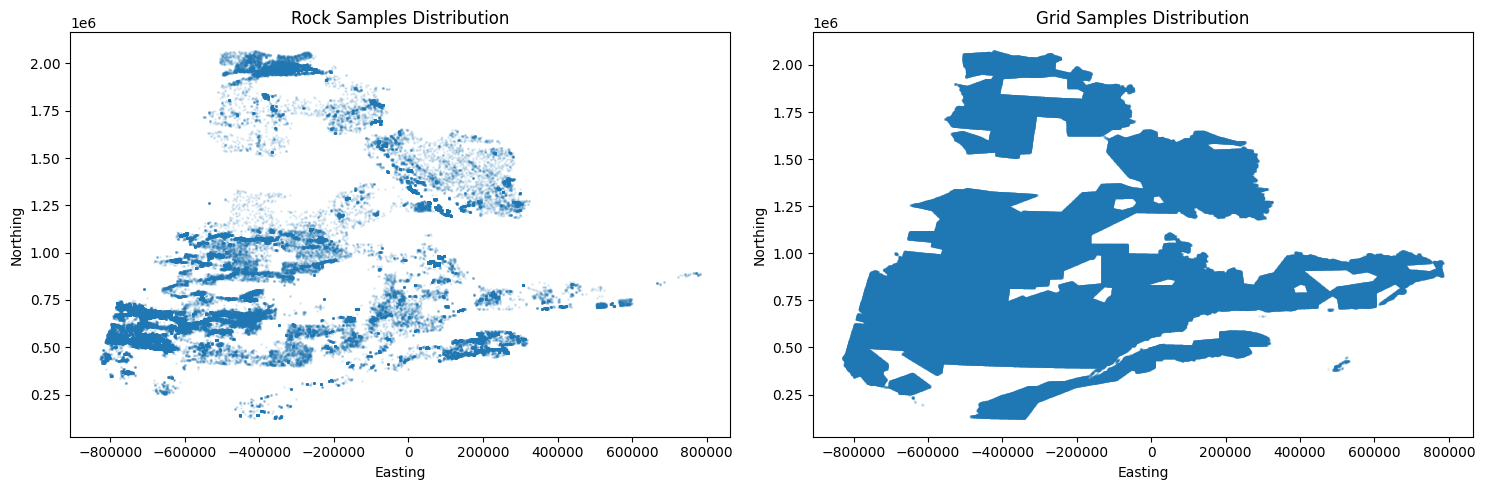

In [2]:
# Cell 2: Analyze Feature Distributions
# Define target thresholds
thresholds = {
    'AU': 100,  # ppb (2.67% samples above)
    'AG': 1,    # ppm (3.60% samples above)
    'CU': 500,  # ppm (2.60% samples above)
    'CO': 100,  # ppm (2.02% samples above)
    'NI': 300   # ppm (4.13% samples above)
}

# Print distribution of target variables in rock samples
print("Target variable distributions in rock samples:")
for element, threshold in thresholds.items():
    if element in rock_samples.columns:
        above_threshold = (rock_samples[element] > threshold).mean() * 100
        print(f"{element}: {above_threshold:.2f}% samples above {threshold}")

# Analyze spatial distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot rock samples
ax1.scatter(rock_samples['Easting'], rock_samples['Northing'], 
           alpha=0.1, s=1, label='Rock Samples')
ax1.set_title('Rock Samples Distribution')
ax1.set_xlabel('Easting')
ax1.set_ylabel('Northing')

# Plot grid samples
ax2.scatter(grid_samples['Easting'], grid_samples['Northing'], 
           alpha=0.1, s=1, label='Grid Samples')
ax2.set_title('Grid Samples Distribution')
ax2.set_xlabel('Easting')
ax2.set_ylabel('Northing')

plt.tight_layout()
plt.show()


Analysis for CODE_LITH:
Unique values in rock samples: 4439
Unique values in grid samples: 5398
Values unique to rock samples: 388
Values unique to grid samples: 1347
Common values: 4051


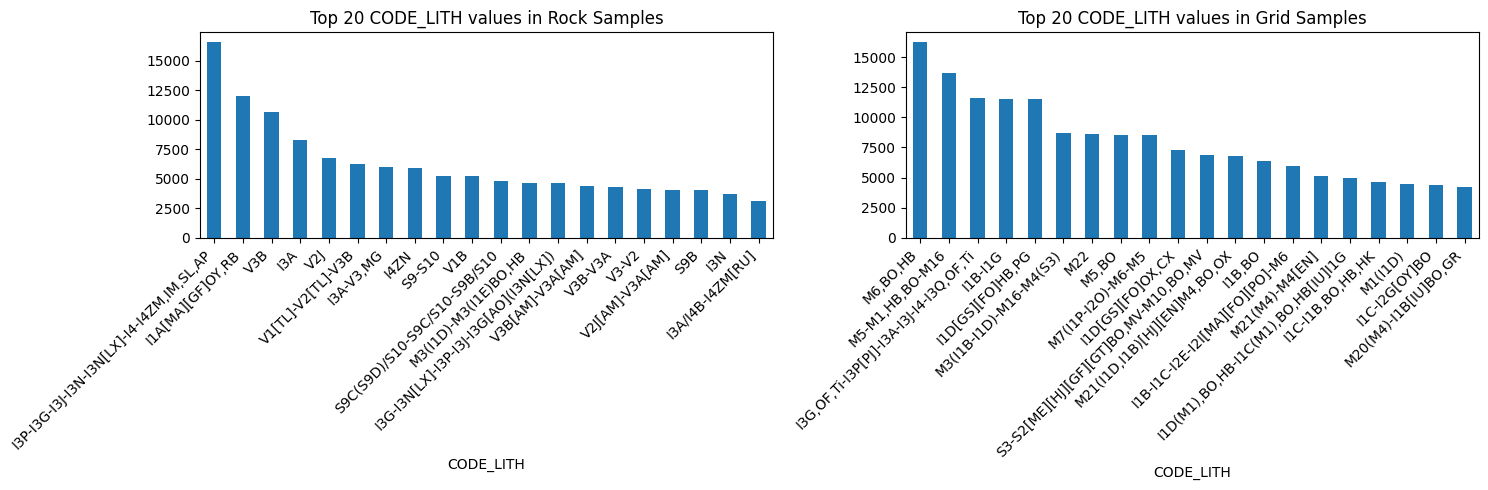


Analysis for STRAT:
Unique values in rock samples: 3608
Unique values in grid samples: 4180
Values unique to rock samples: 303
Values unique to grid samples: 875
Common values: 3305


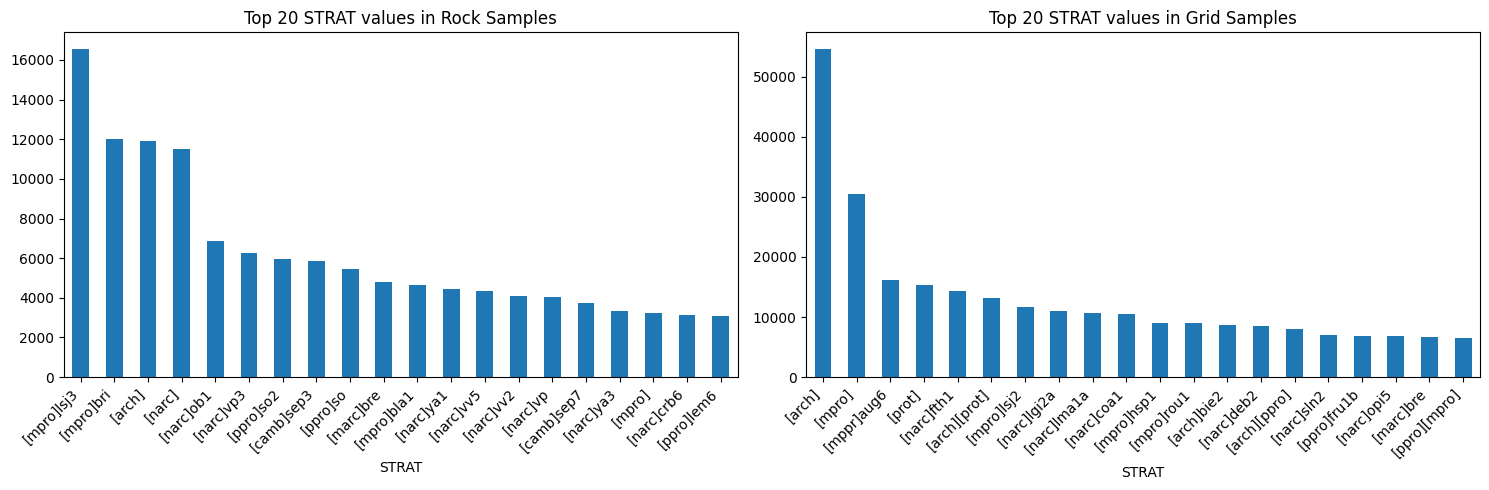

In [3]:
# Cell 3: Analyze Categorical Features
def analyze_categorical_overlap(rock_df, grid_df, column):
    """Analyze overlap between rock and grid samples for a categorical column"""
    rock_values = set(rock_df[column].unique())
    grid_values = set(grid_df[column].unique())
    
    print(f"\nAnalysis for {column}:")
    print(f"Unique values in rock samples: {len(rock_values)}")
    print(f"Unique values in grid samples: {len(grid_values)}")
    print(f"Values unique to rock samples: {len(rock_values - grid_values)}")
    print(f"Values unique to grid samples: {len(grid_values - rock_values)}")
    print(f"Common values: {len(rock_values & grid_values)}")
    
    # Plot value distributions
    plt.figure(figsize=(15, 5))
    
    # Get value counts
    rock_counts = rock_df[column].value_counts().head(20)
    grid_counts = grid_df[column].value_counts().head(20)
    
    # Plot
    plt.subplot(1, 2, 1)
    rock_counts.plot(kind='bar')
    plt.title(f'Top 20 {column} values in Rock Samples')
    plt.xticks(rotation=45, ha='right')
    
    plt.subplot(1, 2, 2)
    grid_counts.plot(kind='bar')
    plt.title(f'Top 20 {column} values in Grid Samples')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Analyze categorical columns
categorical_cols = ['CODE_LITH', 'STRAT']
for col in categorical_cols:
    analyze_categorical_overlap(rock_samples, grid_samples, col)

Encoding Ensights:

Spatial Distribution:

Rock samples are clustered in specific regions
Grid samples cover the entire area systematically
This confirms our need to handle potential sampling bias


Feature Overlap:

CODE_LITH: 1,347 values in grid samples not in rock samples
STRAT: 875 values in grid samples not in rock samples
This is crucial for encoding strategy

In [4]:
# Cell 4: Enhanced Encoding Strategy
def create_unified_encoder(rock_df, grid_df, column):
    """
    Create an encoder that handles values from both datasets
    and has a special token for unknown values
    """
    # Combine unique values from both datasets
    all_values = pd.concat([
        rock_df[column].dropna(),
        grid_df[column].dropna()
    ]).unique()
    
    # Create encoder with an unknown token
    encoder = LabelEncoder()
    encoder.fit(list(all_values) + ['UNKNOWN'])
    
    return encoder

def encode_with_fallback(series, encoder):
    """Encode values with fallback to unknown token for new values"""
    # Create a copy to avoid modifying the original
    encoded = series.copy()
    
    # Replace any values not seen during training with 'UNKNOWN'
    encoded[~series.isin(encoder.classes_)] = 'UNKNOWN'
    
    # Encode using the encoder
    return encoder.transform(encoded)

# Create unified encoders
encoders = {}
for col in ['CODE_LITH', 'STRAT']:
    encoders[col] = create_unified_encoder(rock_samples, grid_samples, col)
    
    # Print some statistics
    print(f"\nEncoding stats for {col}:")
    print(f"Total unique values: {len(encoders[col].classes_)}")
    print("Sample mappings:")
    for val in list(encoders[col].classes_)[:5]:
        print(f"{val} -> {encoders[col].transform([val])[0]}")


Encoding stats for CODE_LITH:
Total unique values: 5787
Sample mappings:
(I1B-I1C) [MA][FO]BO,MG -> 0
(I1D-I2I),BO,CX,HB -> 1
(I1D-I2J-I3A)(M1) -> 2
(I2F-I2E)[FO][OE] -> 3
(I3A-I3Q)[GF][GM][MA][FO][GS][MN] -> 4

Encoding stats for STRAT:
Total unique values: 4484
Sample mappings:
UNKNOWN -> 0
[arch] -> 1
[arch]1 -> 2
[arch][ppro] -> 3
[arch][ppro]ASH -> 4


In [6]:
# Cell 5: Prepare Features
import os

def prepare_features(df, is_training_data=True):
    """
    Prepare features for either training (rock) or prediction (grid) data
    """
    # Create output dataframe
    output = pd.DataFrame()
    
    # Add encoded categorical features
    for col in ['CODE_LITH', 'STRAT']:
        output[f'{col}_encoded'] = encode_with_fallback(df[col], encoders[col])
    
    # Scale numerical features
    scaler = StandardScaler()
    numerical_features = ['dist_fault', 'dist_cont']
    
    # Create directories if they don't exist
    os.makedirs('../../models', exist_ok=True)
    os.makedirs('../../data/processed', exist_ok=True)
    
    if is_training_data:
        # Fit and transform if training data
        output[numerical_features] = scaler.fit_transform(df[numerical_features])
        # Save the scaler
        np.save('../../models/scaler_params.npy', 
                [scaler.mean_, scaler.scale_])
    else:
        # Load scaler parameters and transform
        scaler_mean, scaler_scale = np.load('../../models/scaler_params.npy')
        output[numerical_features] = (df[numerical_features] - scaler_mean) / scaler_scale
    
    # Add coordinates
    output['Easting'] = df['Easting']
    output['Northing'] = df['Northing']
    
    # Add UNIQUE_ID
    output['UNIQUE_ID'] = df['UNIQUE_ID']
    
    # Add targets if training data
    if is_training_data:
        for element in ['AU', 'AG', 'CU', 'CO', 'NI']:
            output[f'{element}_target'] = (df[element] > thresholds[element]).astype(int)
    
    return output

# Prepare both datasets
rock_features = prepare_features(rock_samples, is_training_data=True)
grid_features = prepare_features(grid_samples, is_training_data=False)

# Save prepared datasets
rock_features.to_csv('../../data/processed/rock_features.csv', index=False)
grid_features.to_csv('../../data/processed/grid_features.csv', index=False)

print("\nRock features shape:", rock_features.shape)
print("Grid features shape:", grid_features.shape)
print("\nRock features columns:", rock_features.columns.tolist())

# Print sample of encoded values to verify
print("\nSample of encoded rock features:")
print(rock_features.head())
print("\nSample of encoded grid features:")
print(grid_features.head())


Rock features shape: (434850, 12)
Grid features shape: (1107289, 7)

Rock features columns: ['CODE_LITH_encoded', 'STRAT_encoded', 'dist_fault', 'dist_cont', 'Easting', 'Northing', 'UNIQUE_ID', 'AU_target', 'AG_target', 'CU_target', 'CO_target', 'NI_target']

Sample of encoded rock features:
   CODE_LITH_encoded  STRAT_encoded  dist_fault  dist_cont     Easting  \
0               5501           1943   -0.359526  -0.186135 -798781.171   
1               5491           2265   -0.372944  -0.518361 -805741.770   
2               5501           1943   -0.324028   1.300815 -802893.614   
3               5501           1943   -0.122592  -0.161944 -801759.100   
4               5501           1943   -0.201570   0.200923 -804700.576   

     Northing  UNIQUE_ID  AU_target  AG_target  CU_target  CO_target  \
0  564263.912          1          0          0          0          0   
1  563587.494          2          0          0          0          0   
2  565515.553          3          0          

In [7]:
# Create Training/data/preprocessed directory if it doesn't exist
os.makedirs('/Users/ramiab/Desktop/Mineral-Predictions-Local/Training/data/preprocessed', exist_ok=True)

# Move processed files to training directory
rock_features.to_csv('/Users/ramiab/Desktop/Mineral-Predictions-Local/Training/data/preprocessed/rock_features.csv', index=False)
grid_features.to_csv('/Users/ramiab/Desktop/Mineral-Predictions-Local/Training/data/preprocessed/grid_features.csv', index=False)